In [1]:
import os
import IPython.display as ipd
import numpy as np

In [2]:
def getFilesInDirectory(directory):
    files = []
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            files.append(os.path.abspath(os.path.join(dirpath, f)))
    return files

In [3]:
def getInfo(path):
    head, fileName = os.path.split(path)
    head , curClass = os.path.split(head)
    return os.path.splitext(fileName)[0], curClass

In [4]:
def createDirectory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


In [5]:
files = getFilesInDirectory('RAVDESS')
len(files)

1440

In [6]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy

d:\programs\python 3.8\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
d:\programs\python 3.8\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [7]:
def getParams(sample_rate):
    n_fft = 400.0
    frame_length = n_fft / sample_rate * 1000.0
    frame_shift = frame_length / 2.0
    params = {
        "channel": 0,
        "dither": 0.0,
        "window_type": "hanning",
        "frame_length": frame_length,
        "frame_shift": frame_shift,
        "remove_dc_offset": False,
        "round_to_power_of_two": False,
        "sample_frequency": sample_rate,
    }
    return params

In [8]:
dirOutput = 'RAVDESS_spectogram_Kaldi_4emotions'

In [9]:
emotions = ['calmado', 'neutral', 'feliz', 'triste', 'molesto',  'miedo', 'disgusto', 'sorprendido']
selected = ['neutral', 'feliz', 'triste', 'molesto']

In [10]:
def printProgress(i, lenFiles):
    step = round( lenFiles / 100);
    if i % step == step - 1:
        percent = round(100.0 * (i + 1) /  lenFiles);
        print(percent, "%  completed");

In [11]:
def printImage(spectrogramKaldi, figFile):
    #plt.figure()
    plt.axis('off')
    plt.imshow(spectrogramKaldi.t().numpy(), aspect='auto', cmap = 'magma')
    plt.savefig(figFile, bbox_inches='tight')

In [12]:
def deleteSilence(waveform, sample_rate):
    waveform = torchaudio.functional.vad(waveform, sample_rate = sample_rate, trigger_level = 1.0)
    waveform = torch.flip(waveform, [1])
    waveform = torchaudio.functional.vad(waveform, sample_rate = sample_rate, trigger_level = 1.0)
    waveform = torch.flip(waveform, [1])
    return waveform

In [169]:
def augment(waveform):
    return torchaudio.transforms.Vol(np.random.uniform(1.0, 2.5),gain_type = 'db').forward(waveform)

  0%|                                                                                         | 0/1440 [00:00<?, ?it/s]d:\programs\python 3.8\lib\site-packages\torchaudio\functional.py:2076: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  _dftBuf = torch.rfft(dftBuf, 1)
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [28:56<00:00,  1.21s/it]


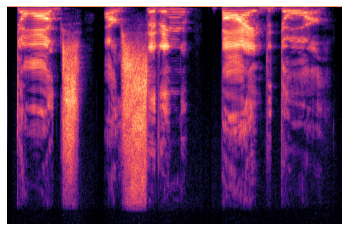

In [13]:
from tqdm import tqdm
train_emotions = []
valid_emotions = []
for i in tqdm(range(len(files))):
    #printProgress(i, len(files))
    curFile = files[i]
    fileName, actor = getInfo(curFile)
    intEmotion = int(fileName[6]) * 10 + int(fileName[7]) - 1
    emotion = emotions[intEmotion]
    if emotion not in selected:
        continue
    
    folder = 'train'
    if actor >= "Actor_20":
        folder = 'valid'
    if folder == 'train':
        train_emotions.append(emotion)
    else:
        valid_emotions.append(emotion)
   
    curDir = dirOutput + "/" + folder + "/" + emotion
    figFile = curDir + "/" + actor + "_" + fileName + ".png"
    
    if os.path.exists(figFile):
        continue
    waveform, sample_rate = torchaudio.load(curFile)
    waveform = deleteSilence(waveform, sample_rate)
    #waveformAugment = augment(waveform)
    
    spectrogramKaldi = torchaudio.compliance.kaldi.spectrogram(waveform, getParams(sample_rate))
 
    createDirectory(curDir)
    #print("Shape of spectrogramKaldi: {}".format(spectrogramKaldi.size()))
    printImage(spectrogramKaldi, figFile)
    
#     spectrogramKaldiAugment = torchaudio.compliance.kaldi.spectrogram(waveformAugment, getParams(sample_rate))
#     for i in range(2):
#         figFileAugment = curDir + "/" + actor + "_" + fileName + "_augment" + str(i) +".png"
#         printImage(spectrogramKaldiAugment, figFileAugment)
#         if folder == 'train':
#             train_emotions.append(emotion)
#         else:
#             valid_emotions.append(emotion)
    
    

In [14]:
from collections import Counter

counter_train = Counter(train_emotions)
total = sum(counter_train.values())
print("Emotions of classic (" , total  , ")")
for k, v in counter_train.most_common():
    print("{:<15}".format(k) , " " , "{:<15}".format(v), "{:<15}".format("{:4.2f}".format(100 * v / total)+ " %"))

print("------------------------------")
counter_valid = Counter(valid_emotions)
total = sum(counter_valid.values())
print("Emotions of others (" , total , ")")

for k, v in counter_valid.most_common():
    print("{:<15}".format(k) , " " , "{:<15}".format(v), "{:<15}".format("{:4.2f}".format(100 * v / total)+ " %"))


Emotions of classic ( 608 )
neutral           152             25.00 %        
feliz             152             25.00 %        
triste            152             25.00 %        
molesto           152             25.00 %        
------------------------------
Emotions of others ( 160 )
neutral           40              25.00 %        
feliz             40              25.00 %        
triste            40              25.00 %        
molesto           40              25.00 %        


In [160]:
ipd.Audio(waveform,rate=sample_rate)

In [161]:
ipd.Audio(waveform2,rate=sample_rate)

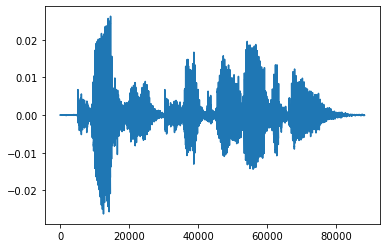

In [153]:
plt.figure()
plt.plot(waveform.t().numpy())

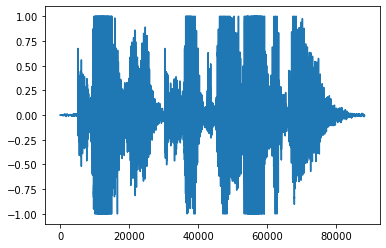

In [154]:
plt.figure()
plt.plot(waveform2.t().numpy())